✅ Dosyalar başarıyla yüklendi.


C:\Users\aysed\AppData\Local\Temp\ipykernel_11868\2817225908.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class_name', data=train_df, palette='viridis')


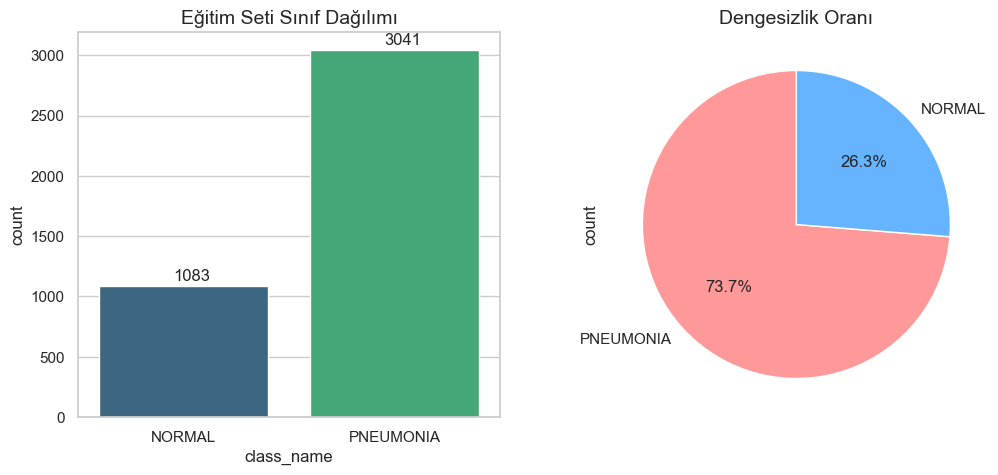


Resimler taranıyor... (Bu işlem biraz sürebilir)
✅ Doğru yol bulundu: c:\Users\aysed\Resilient-XAI-Pneumonia\data


100%|██████████| 4124/4124 [00:23<00:00, 178.42it/s]



🔍 4124 görüntü analiz ediliyor... (Boyut ve Parlaklık)


100%|██████████| 4124/4124 [00:24<00:00, 171.83it/s]



🔍 4124 görüntü analiz ediliyor...


100%|██████████| 4124/4124 [00:23<00:00, 175.39it/s]
C:\Users\aysed\AppData\Local\Temp\ipykernel_11868\2817225908.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_name', y='aspect_ratio', data=df, palette='Set2')


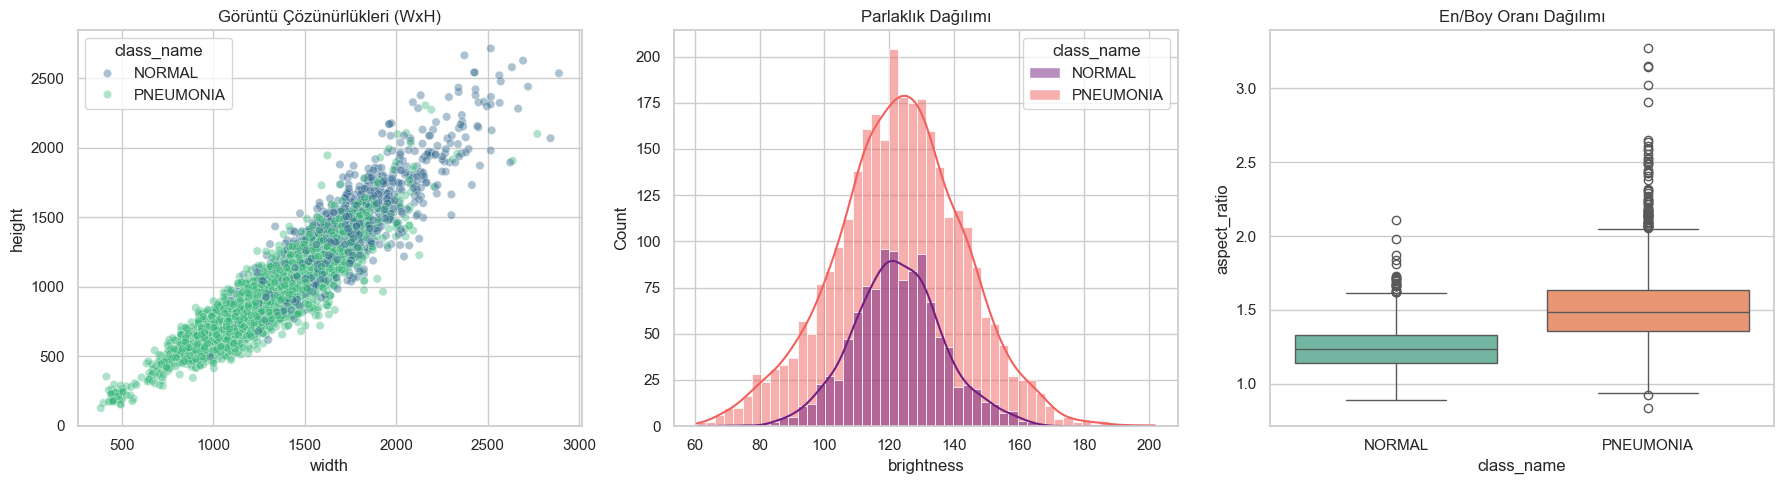


📊 ÖZET:
✅ Analiz edilen: 4124 | 🚨 Ayıklanan (Bozuk): 0
📏 Ortalama Çözünürlük: 1328x971

💡 SINIF BAZLI PARLAKLIK ANALİZİ:
class_name
NORMAL       122.594826
PNEUMONIA    122.853354
Name: brightness, dtype: float64

📏 SINIF BAZLI ORTALAMA BOYUTLAR:
                  width       height
class_name                          
NORMAL      1686.351801  1379.657433
PNEUMONIA   1201.266689   825.670503


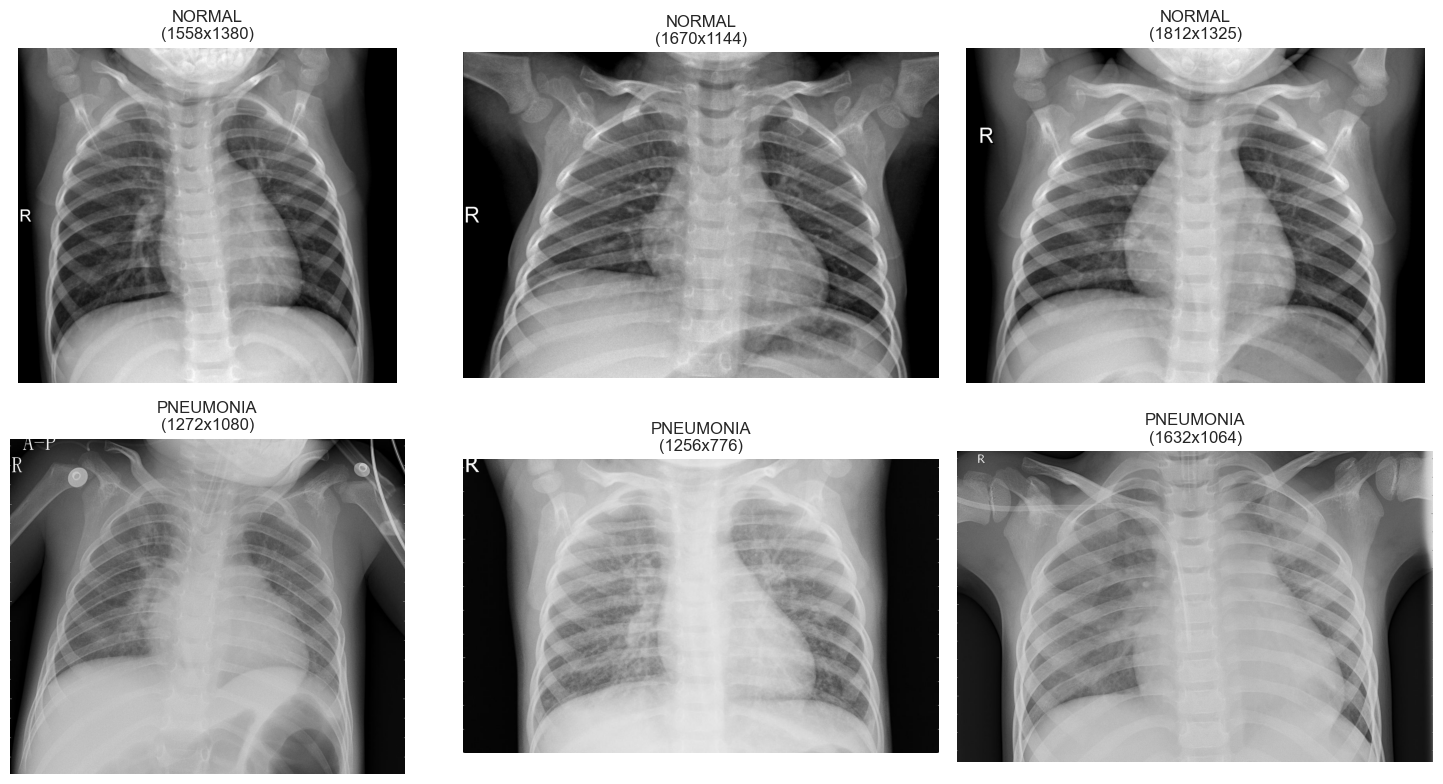

In [1]:
# Pandas ve Numpy yüklemek için
! pVip install pandas numpy matplotlib seaborn opencv-python tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm  # İlerleme çubuğu için

# Grafik stili (Daha profesyonel görünüm için)
sns.set(style="whitegrid")

# VERİ YÜKLEME

try:
    train_df = pd.read_csv('../data/train_list.csv')
    val_df = pd.read_csv('../data/val_list.csv')
    test_df = pd.read_csv('../data/test_list.csv')
    print("✅ Dosyalar başarıyla yüklendi.")
except FileNotFoundError:
    print("❌ HATA: CSV dosyaları bulunamadı! Lütfen dosya yollarını kontrol et.")

label_map = {0: 'NORMAL', 1: 'PNEUMONIA'}
train_df['class_name'] = train_df['label'].map(label_map)

# SINIF DAĞILIMI ANALİZİ

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(x='class_name', data=train_df, palette='viridis')
plt.title('Eğitim Seti Sınıf Dağılımı', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 50))

plt.subplot(1, 2, 2)
train_df['class_name'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Dengesizlik Oranı', fontsize=14)
plt.show()

# PARLAKLIK ANALİZİ 

def calculate_brightness_final(df):
    brightness_values = []
    print("\nResimler taranıyor... (Bu işlem biraz sürebilir)")
    
    possible_roots = ['../data/', '../data/chest_xray/', './data/', './data/chest_xray/']
    active_root = None
    first_file = df['file_path'].iloc[0].replace('\\', '/')
    
    for root in possible_roots:
        if os.path.exists(os.path.join(root, first_file)):
            active_root = root
            print(f"✅ Doğru yol bulundu: {os.path.abspath(active_root)}")
            break
            
    if active_root is None:
        print("❌ HATA: Resim klasörü bulunamadı!")
        return [None] * len(df)

    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        path_in_csv = row['file_path'].replace('\\', '/')
        img_path = os.path.join(active_root, path_in_csv)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness_values.append(np.mean(img))
        else:
            brightness_values.append(None)
    return brightness_values

train_df['brightness'] = calculate_brightness_final(train_df)
plot_df = train_df.dropna(subset=['brightness'])


# GELİŞMİŞ GÖRÜNTÜ VE BOYUT ANALİZİ 

def perform_advanced_analysis(df, root_path='../data/'):
    widths, heights, brightness_vals = [], [], []
    valid_indices = []
    
    # Dosya yolunu doğrula
    possible_roots = [root_path, '../data/chest_xray/', './data/']
    active_root = None
    for r in possible_roots:
        if os.path.exists(r):
            active_root = r
            break
            
    if active_root is None:
        print("❌ HATA: Resim klasörü bulunamadı!")
        return df

    print(f"\n🔍 {len(df)} görüntü analiz ediliyor... (Boyut ve Parlaklık)")
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        path_in_csv = row['file_path'].replace('\\', '/')
        img_path = os.path.join(active_root, path_in_csv)
        
        # Görüntüyü oku
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            h, w = img.shape
            widths.append(w)
            heights.append(h)
            brightness_vals.append(np.mean(img))
            valid_indices.append(idx)
        else:
            # Okunamayan dosyaları takip et
            pass

    # Sadece başarıyla okunanları yeni bir dataframe'e aktar
    analyzed_df = df.loc[valid_indices].copy()
    analyzed_df['width'] = widths
    analyzed_df['height'] = heights
    analyzed_df['brightness'] = brightness_vals
    analyzed_df['aspect_ratio'] = analyzed_df['width'] / analyzed_df['height']
    
    return analyzed_df

# Analizi çalıştır
train_df = perform_advanced_analysis(train_df)

# GELİŞMİŞ ANALİZ VE TEMİZLİK FONKSİYONU

def perform_advanced_analysis(df, root_path='../data/'):
    widths, heights, brightness_vals = [], [], []
    valid_indices = []
    
    # Doğru veri yolunu bul
    possible_roots = [root_path, '../data/chest_xray/', './data/']
    active_root = None
    for r in possible_roots:
        if os.path.exists(r):
            active_root = r
            break
            
    if active_root is None:
        print("❌ HATA: Resim klasörü bulunamadı!")
        return df

    print(f"\n🔍 {len(df)} görüntü analiz ediliyor...")
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        path_in_csv = row['file_path'].replace('\\', '/')
        img_path = os.path.join(active_root, path_in_csv)
        
        # Görüntüyü oku (Sadece boyut ve parlaklık için gri tonlama yeterli)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            h, w = img.shape
            widths.append(w)
            heights.append(h)
            brightness_vals.append(np.mean(img))
            valid_indices.append(idx)

    # Analiz sonuçlarını DataFrame'e ekle
    analyzed_df = df.loc[valid_indices].copy()
    analyzed_df['width'] = widths
    analyzed_df['height'] = heights
    analyzed_df['brightness'] = brightness_vals
    analyzed_df['aspect_ratio'] = analyzed_df['width'] / analyzed_df['height']
    
    return analyzed_df, active_root

# Analizi Başlat
train_df, active_root_path = perform_advanced_analysis(train_df)

# GÖRSELLEŞTİRME VE OUTLIER TEMİZLİĞİ

def plot_and_clean_data(df):
    plt.figure(figsize=(18, 5))

    # Grafik 1: Çözünürlük Dağılımı
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df, x='width', y='height', hue='class_name', alpha=0.4, palette='viridis')
    plt.title('Görüntü Çözünürlükleri (WxH)')

    # Grafik 2: Parlaklık Histogramı
    plt.subplot(1, 3, 2)
    sns.histplot(data=df, x='brightness', hue='class_name', kde=True, palette='magma')
    plt.title('Parlaklık Dağılımı')

    # Grafik 3: En/Boy Oranı
    plt.subplot(1, 3, 3)
    sns.boxplot(x='class_name', y='aspect_ratio', data=df, palette='Set2')
    plt.title('En/Boy Oranı Dağılımı')

    plt.tight_layout()
    plt.show()
    plt.close()

    # --- TEMİZLİK ---
    # Çok karanlık (<10) veya çok parlak (>245) resimleri ayıkla
    bad_data = df[(df['brightness'] < 10) | (df['brightness'] > 245)]
    clean_df = df.drop(bad_data.index)
    
    print(f"\n📊 ÖZET:")
    print(f"✅ Analiz edilen: {len(df)} | 🚨 Ayıklanan (Bozuk): {len(bad_data)}")
    print(f"📏 Ortalama Çözünürlük: {int(clean_df['width'].mean())}x{int(clean_df['height'].mean())}")
    
    return clean_df

train_df = plot_and_clean_data(train_df)
# Sınıf bazlı ortalama parlaklık farkını yazdır
print("\n💡 SINIF BAZLI PARLAKLIK ANALİZİ:")
print(train_df.groupby('class_name')['brightness'].mean())

# Eğer istersen sınıflar arası boyut farkını da görebilirsin
print("\n📏 SINIF BAZLI ORTALAMA BOYUTLAR:")
print(train_df.groupby('class_name')[['width', 'height']].mean())

# ÖRNEK RESİMLERİ GÖRSELLEŞTİRME

def show_sample_images(df, root):
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        samples = df[df['class_name'] == class_name].sample(3)
        for j, (idx, row) in enumerate(samples.iterrows()):
            img_path = os.path.join(root, row['file_path'].replace('\\', '/'))
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(2, 3, i*3 + j + 1)
                plt.imshow(img)
                plt.title(f"{class_name}\n({row['width']}x{row['height']})")
                plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

show_sample_images(train_df, active_root_path)